#Neuron counting with the Two Photon Random Access Mesoscope

This notebook contains code for counting the number of neurons in a volume of brain data collected with the 2P-RAM. The data consists of a (351, 3708, 4608) pixel volume covering (700 um, 4405 um, 5310 um) of brain in (z, y, x). Each image is the average of 20 acquisitions. The data comes from an emx-cre x lsl-h2b-gfp transgenic mouse that expresses GFP inside the nuclei of its excitatory neurons.

##Import the data

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/python-2.7.6/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from numpy import array

In [3]:
from showit import image
import matplotlib.animation as animation

In [4]:
import thunder

In [5]:
import json

In [6]:
from os.path import join, exists
from os import mkdir, makedirs

##Set directory and session information

In [7]:
directory = '/tier2/freeman/Nick/lfov.calibration'

In [8]:
key = '2016-04-28'
name = 'anm-0334363-5'

In [9]:
path = join(directory, 'reprocessed', name, key)
print exists(path)

True


####Create savepath

In [10]:
savepath = join(path, 'movies')
if not exists(savepath):
    makedirs(savepath)

####Create movie

In [11]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=40000)

####Load data

In [12]:
data = thunder.images.frombinary(join(path, 'images'), engine=sc, stop=300)

##Smooth and downsample data

We will first median filter and downsample each depth slice to reduce the data size before trying to detect nuclei

In [13]:
from scipy.ndimage.filters import maximum_filter

In [14]:
filtered = data.gaussian_filter(1).subsample(2)

normalize

In [15]:
avg = filtered.map(lambda x: x.max()).toarray()

In [16]:
from scipy.ndimage.filters import gaussian_filter1d

In [17]:
from numpy import Inf
avg_gf = gaussian_filter1d(avg,10)

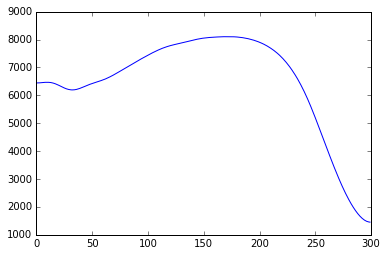

In [18]:
plt.plot(avg_gf)

In [19]:
raw = filtered.toarray()

In [20]:
from numpy import asarray

In [21]:
norm = asarray([raw[i,:,:].astype('float32')/avg_gf[i] for i in range(len(avg_gf))])

###Find local maxima in the images

In [22]:
from skimage.feature import peak_local_max

In [23]:
centers = peak_local_max(norm, min_distance=2, threshold_rel=.075, exclude_border=True)

In [24]:
len(centers)

207359

In [201]:
from pandas import DataFrame

In [203]:
DataFrame(centers).to_csv(join(path, 'summary','centers.csv'))

##Reconsitute volume

In [290]:
ds = thunder.images.fromarray([norm]).map(lambda x: maximum_filter(x,(5, 1, 1))).subsample((5, 1, 1)).toarray()

In [24]:
from skimage.io import imsave

In [291]:
imsave(join(path, 'summary', 'stackQ_New.tif'), ds.astype('float32'), plugin='tifffile', photometric='minisblack')

In [323]:
centers_ds =[[x[0]/5, x[1], x[2]] for x in centers]

In [324]:
from numpy import tile

In [325]:
max_val = .75

In [326]:
col = tile(ds,(3,1,1,1)).transpose(1,2,3,0)
for x in centers_ds:
    col[x[0], x[1], x[2], :] = [max_val, 0, 0]
    if (x[1] != ds.shape[1]-1) and (x[2] !=ds.shape[2]-1) :
        col[x[0], x[1], x[2]+1, :] = [max_val, max_val/2, max_val/2]
        col[x[0], x[1], x[2]-1, :] = [max_val, max_val/2, max_val/2]
        col[x[0], x[1]+1, x[2], :] = [max_val, max_val/2, max_val/2]
        col[x[0], x[1]-1, x[2], :] = [max_val, max_val/2, max_val/2]
    if (x[0] != 0):
        col[x[0]-1, x[1], x[2], :] = [max_val, max_val/2, max_val/2]
    if (x[0] != ds.shape[0]-1):
        col[x[0]+1, x[1], x[2], :] = [max_val, max_val/2, max_val/2]

In [327]:
imsave(join(path, 'summary', 'stackColQ_new.tif'), (255*(col/max_val).clip(0,1)).astype('uint8'), plugin='tifffile', photometric='rgb')

## Detected nuclei by depth

In [25]:
from pandas import DataFrame

In [26]:
centers_df = DataFrame(centers)

In [27]:
num_gp = centers_df.groupby([0]).count()[1]

In [28]:
from numpy import zeros

In [29]:
num = zeros(norm.shape[0])
num[num_gp.index] = num_gp.values

In [176]:
depths = [2*x for x in range(norm.shape[0])]

In [31]:
from scipy.ndimage.filters import median_filter

In [177]:
sum(num)

207359.0

In [178]:
import seaborn as sns
sns.set_context('paper', font_scale=2.0)
sns.set_style('ticks')

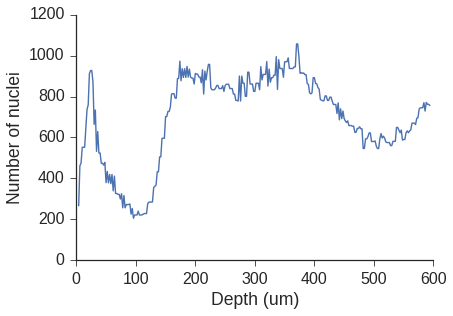

In [183]:
plt.plot(depths[2:-2], median_filter(num[2:-2],3))
plt.xlabel('Depth (um)')
plt.ylabel('Number of nuclei')
plt.ylim([0, 1200])
sns.despine()
plt.savefig(join(path, 'summary', 'DepthProfile.eps'))

##Sumary images

max projection from 100um to 200um deep across whole brain

In [209]:
img = data[50:100].max().toarray()

In [210]:
from skimage.exposure import equalize_adapthist
img_adj = equalize_adapthist(img, ntiles_x = 10, ntiles_y = 10, clip_limit=0.02, nbins = 256)

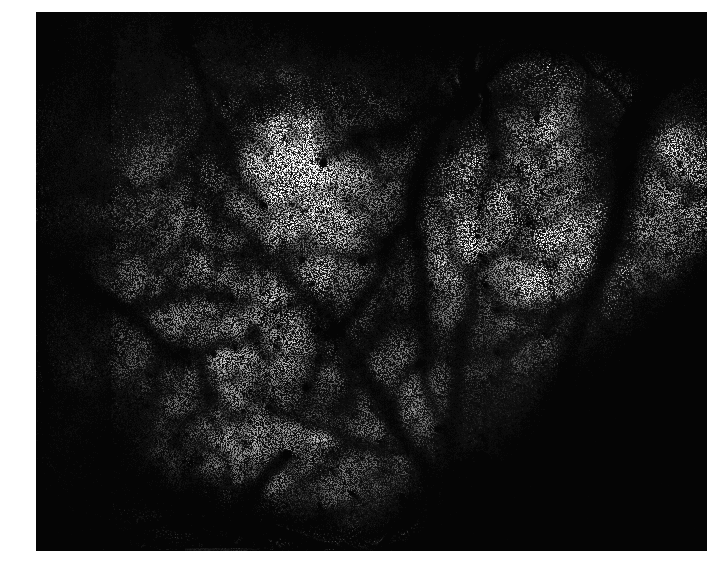

In [232]:
image(img_adj, clim = (0, .8), size = 12);

In [188]:
imsave(join(path, 'summary', 'max_proj.tif'), img_adj.astype('float32'), plugin='tifffile', photometric='minisblack')

500um x 500um patch with neurons labeled

In [35]:
from numpy import tile

In [158]:
img = data[75].toarray().astype('float32')/7000

In [ ]:
img = norm[75]

In [ ]:
img

In [164]:
max_val = 1.0
raw_col = tile(img,(3,1,1)).transpose(1,2,0)
for x in centers:
    if (x[0]>70) and (x[0]<80) and (img[2*x[1], 2*x[2]] > .2):
        raw_col[2*x[1], 2*x[2], :] = [max_val, 0, 0]
        raw_col[2*x[1], 2*x[2]+1, :] = [max_val, max_val/2, max_val/2]
        raw_col[2*x[1], 2*x[2]-1, :] = [max_val, max_val/2, max_val/2]
        raw_col[2*x[1]+1, 2*x[2], :] = [max_val, max_val/2, max_val/2]
        raw_col[2*x[1]-1, 2*x[2], :] = [max_val, max_val/2, max_val/2]

    if (x[0]>71) and (x[0]<79) and (img[2*x[1], 2*x[2]] <= .2):
        raw_col[2*x[1], 2*x[2], :] = [max_val, max_val/2, max_val/2]

    #if (x[0]==72) or (x[0]==78):
        #raw_col[x[1], x[2], :] = [max_val, max_val/2, max_val/2]


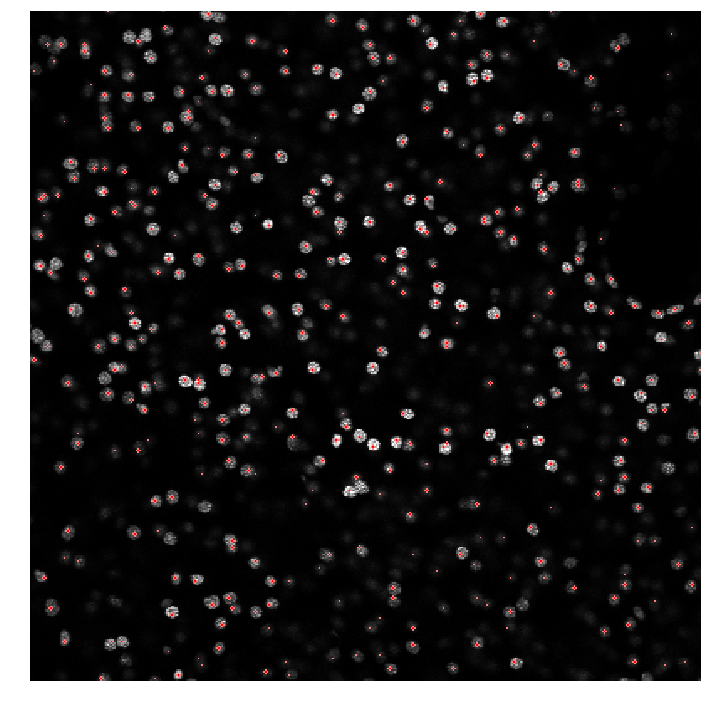

In [165]:
image((raw_col[2*400+100:2*650,2*750+100:2*1000]).clip(0,1), size=12)

In [166]:
from skimage.io import imsave

In [168]:
imsave(join(path, 'summary', 'detected.tif'), (255*raw_col[2*400+100:2*650,2*750+100:2*1000].clip(0,1)).astype('uint8'), plugin='tifffile', photometric='rgb')

In [200]:
#scale bar
1.8657/(meta['rois'][0]['size'][0]/meta['rois'][0]['npixels'][0]*400)*.050

0.20238101694915256

##Load meta data

In [131]:
summarypath = join(directory, 'reprocessed', name, key, 'summary')
with open(summarypath + '/meta.json') as infile:
    meta = json.load(infile)

In [132]:
pixelsPerUmOrig = meta['rois'][0]['npixels'][0]/meta['rois'][0]['size'][0]/1000
aspect = meta['rois'][0]['size'][0]/meta['rois'][0]['size'][1]
volumeRate = meta['volumeRate']
scaleBar = 100*round(meta['rois'][0]['size'][0]*1.8)
depths = meta['depths']

In [133]:
depths = meta['depths']

In [134]:
meta['rois']

[{u'center': [3.0450848452893466, 3.1465],
  u'depths': 0.0,
  u'npixels': [4608.0, 3708.0],
  u'size': [5.31, 4.4051]}]

##Transform data

In [186]:
fSpace = 2
dsTime = 1
dsSpace = 2
frameRate = volumeRate/dsTime
pixelsPerUm = pixelsPerUmOrig/dsSpace

##Extract single plane

In [224]:
movie = norm
means = movie.mean()
label = 'movie3'
clim = means*14 #3.0/4 #means
plane = 0

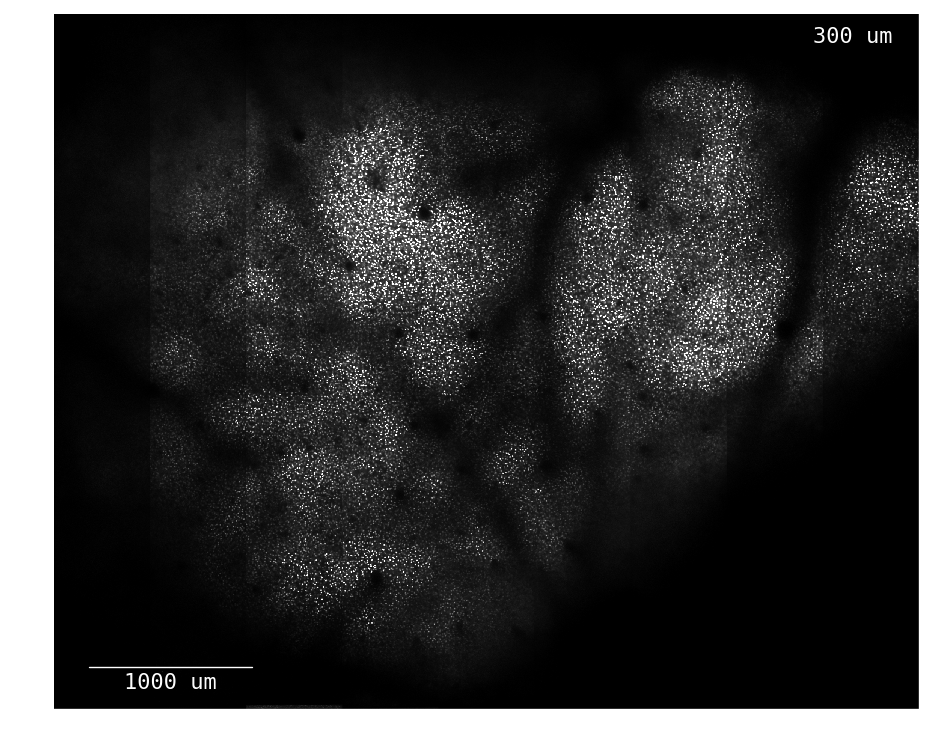

In [230]:
frame = movie.shape[0]/2
img = movie[frame,:,:]

fig = plt.figure(figsize=[12, 12.0*img.shape[0]/img.shape[1]])
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
ax = plt.gca()
im = image(img, clim=(0, clim), ax=ax)

time = ax.text(.97*img.shape[1], .04*img.shape[0], '%.0f um' % (depths[frame]), color='white', fontsize=22, ha='right', fontdict={'family': 'monospace'});
ax.plot([.04*img.shape[1], .04*img.shape[1]+scaleBar*pixelsPerUm], [.94*img.shape[0], .94*img.shape[0]], 'w');
sclae = ax.text(.04*img.shape[1]+scaleBar*pixelsPerUm/2, .97*img.shape[0], '%d um' % scaleBar, color='white', fontsize=22, ha='center', fontdict={'family': 'monospace'});
plt.xlim([0, img.shape[1]]);
plt.ylim([img.shape[0], 0]);

In [231]:
nframes = movie.shape[0]

def update(frame):
    im.set_array(movie[frame,:,:])
    time.set_text('%.0f um' % (depths[frame]))

ani = animation.FuncAnimation(fig, update, nframes, blit=False)
ani.save(join(savepath, '%s_ds%d_fs%d_dt%d-%d.mp4' % (label, dsSpace, fSpace, dsTime, plane)), writer=writer)

In [215]:
#from skimage.io import imsave

In [54]:
#imsave(join(path, 'summary', 'stackAll.tif'), (255*(movie.astype('float32')/1000).clip(0,1)).astype('uint8'), plugin='tifffile', photometric='minisblack')